In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.1 MB/s eta 0:00:00 MB/s eta 0:00:0101


# Imports

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

SEED = 123

# Agents

In [4]:
class n_SARSA:
    def __init__(self, n_states, n_actions):
        # setting parameters
        self.Q = np.zeros((n_states, n_actions))

        # hyperparameters to tune
        self.lrate = 0.15
        self.drate = 0.95
        print("[n-step SARSA AGENT SET]\n")

    def update(self, states, actions, rewards, tau, global_t, done):
        td_target = 0
        for i in range(tau , min(tau+n, global_t) ):
            td_target += np.power(self.drate, i - tau ) * rewards[i]

        if tau + n < global_t:
            q_vals_next = np.power(self.drate, n) * self.Q[states[tau+n], actions[tau+n]] * (1-done) # Q(s',a')
            td_target += q_vals_next

        td_error = td_target - self.Q[states[tau], actions[tau]]
        self.Q[states[tau], actions[tau]] += self.lrate * td_error

        return self.Q[states[tau], actions[tau]]

class QLearning:
    def __init__(self, n_states, n_actions):
        # setting parameters
        self.Q = np.zeros((n_states, n_actions))

        # hyperparameters to tune
        self.lrate = 0.15
        self.drate = 0.95
        print("[QLearning AGENT SET]\n")

    def update(self, state, action, reward, next_state, done):
        # Qlearning algorithm: Q(s,a) := Q(s,a) + learning_rate * (reward + discount_rate * max_a' Q(s',a') - Q(s,a))
        td_target = reward + self.drate * (1 - done) * np.max(self.Q[next_state, :])
        td_error = td_target - self.Q[state, action]
        self.Q[state, action] += self.lrate * td_error

        return self.Q[state, action]

class n_QLearning:
    def __init__(self, n_states, n_actions):
        # setting parameters
        self.Q = np.zeros((n_states, n_actions))

        # hyperparameters to tune
        self.lrate = 0.15
        self.drate = 0.95
        print("[n-step QLearning AGENT SET]\n")

    def update(self, states, actions, rewards, tau, global_t, done):
        td_target = 0
        for i in range(tau , min(tau+n, global_t) ):
            td_target += np.power(self.drate, i - tau ) * rewards[i]

        if tau + n < global_t:
            q_vals_next = np.power(self.drate, n) * self.Q[states[tau+n]][ np.argmax(self.Q[states[tau+n]]) ] * (1-done)
            td_target += q_vals_next

        td_error = td_target - self.Q[states[tau], actions[tau]]
        self.Q[states[tau], actions[tau]] += self.lrate * td_error

        return self.Q[states[tau], actions[tau]]

# Environment

In [5]:
GAME = "Taxi-v3"
env = gym.make(GAME, max_episode_steps=300)
np.random.seed(SEED)  # Make plots reproducible

n_states = env.observation_space.n
n_actions = env.action_space.n

print(n_states, n_actions)


epsilon = .2     # probability that our agent will explore

# Choose an action using epsilon-greedy strategy
def choose_action(agent, state):

    if np.random.uniform(0, 1) < epsilon:
        return env.action_space.sample()  # Explore
    else:
        return np.argmax(agent.Q[state, :])  # Exploit

    
def evaluate_policy(env, Q, episodes=10):
    total_rewards = 0
    for _ in range(episodes):
        state = env.reset()[0]
        done = False
        while not done:
            action = np.argmax(Q[state])  # Choose the best action based on learned Q-values

            state, reward, done, truncated, _ = env.step(action)
            total_rewards += reward
            if truncated:
                break

    average_reward = total_rewards / episodes

    return average_reward

500 6


# Training

## $n$-step SARSA

In [6]:
EPISODES = 500
RUNS = 10

average_cumulative_reward = 0.0
runs_list = np.zeros(shape=(RUNS, EPISODES))
n = 4  # n-step SARSA


for i in range(RUNS):
    agent = n_SARSA(n_states, n_actions)
    avg_cumulative_list = []
    print(f"Agent: {i+1}")

    for ep in range(EPISODES):
        state = env.reset()[0]
        action = choose_action(agent, state)
        states = [state]
        actions = [action]
        rewards = []

        done = False
        cumulative_reward = 0.0
        T = float('inf')
        t = 0

        while True:
            if t < T:
                next_state, reward, done, truncated, info = env.step(action)  # Take action
                rewards.append(reward)
                states.append(next_state)

                if done or truncated:
                    T = t + 1
                else:
                    next_action = choose_action(agent, next_state) # Choose next action
                    actions.append(next_action)
            tau = t - n + 1 # Time whose state's estimate is being updated, state to be updated
            if tau >= 0:
                agent.update(states, actions, rewards, tau, T, done)

                # Update statistics
                cumulative_reward += rewards[tau] # np.mean(rewards)
            state, action = next_state, next_action.copy()
            if tau == T - 1:
                break
            t += 1
        # Per-episode statistics
        average_cumulative_reward *= 0.95
        average_cumulative_reward += 0.05 * cumulative_reward
        avg_cumulative_list.append(average_cumulative_reward)

        if ep % 50 == 0:
            print(f"Episode: {ep} \tAvg cumul reward: {average_cumulative_reward:.4f}")

    print()
    runs_list[i] = np.array(avg_cumulative_list)

avg_ql = evaluate_policy(env, agent.Q, 10)
print(f"\n- Avg reward over 10 episodes: {avg_ql}\n")

[n-step SARSA AGENT SET]

Agent: 1
Episode: 0 	Avg cumul reward: -44.7000
Episode: 50 	Avg cumul reward: -781.9252
Episode: 100 	Avg cumul reward: -505.6175
Episode: 150 	Avg cumul reward: -281.6471
Episode: 200 	Avg cumul reward: -237.1093
Episode: 250 	Avg cumul reward: -97.4229
Episode: 300 	Avg cumul reward: -97.7847
Episode: 350 	Avg cumul reward: -68.8178
Episode: 400 	Avg cumul reward: -55.5124
Episode: 450 	Avg cumul reward: -33.6231

[n-step SARSA AGENT SET]

Agent: 2
Episode: 0 	Avg cumul reward: -71.3649
Episode: 50 	Avg cumul reward: -695.5998
Episode: 100 	Avg cumul reward: -501.3091
Episode: 150 	Avg cumul reward: -360.7773
Episode: 200 	Avg cumul reward: -153.5819
Episode: 250 	Avg cumul reward: -110.5038
Episode: 300 	Avg cumul reward: -89.5074
Episode: 350 	Avg cumul reward: -42.4220
Episode: 400 	Avg cumul reward: -35.7965
Episode: 450 	Avg cumul reward: -30.6182

[n-step SARSA AGENT SET]

Agent: 3
Episode: 0 	Avg cumul reward: -72.4097
Episode: 50 	Avg cumul reward: 

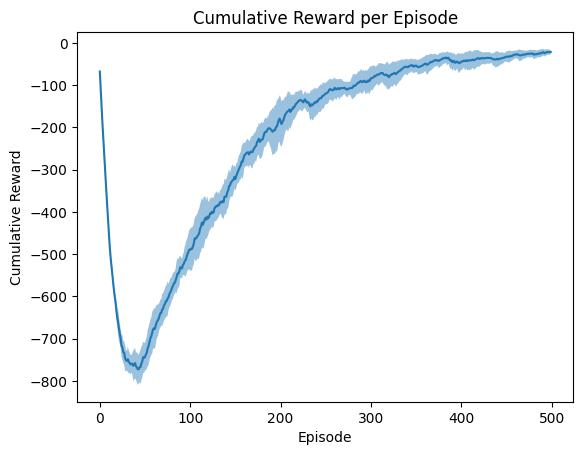

In [7]:
means_Nsarsa = np.mean(runs_list, axis=0)
stds_Nsarsa = np.std(runs_list, axis=0)

plt.plot(means_Nsarsa)
plt.fill_between(range(EPISODES), means_Nsarsa-stds_Nsarsa, means_Nsarsa+stds_Nsarsa, alpha=.45)
plt.title('Cumulative Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward');

## Q Learning

In [8]:
EPISODES = 500
RUNS= 10
average_cumulative_reward = 0.0
runs_list = np.zeros(shape=(RUNS, EPISODES))
avg_list = np.zeros(shape=(RUNS))

for i in range(RUNS):
    agent = QLearning(n_states, n_actions)
    avg_cumulative_list = []
    print(f"Agent: {i+1}")

    for ep in range(EPISODES):
        state = env.reset()[0]
        done = False
        cumulative_reward = 0.0

        while not done:
            action = choose_action(agent, state) # Choose  action
            next_state, reward, done, truncated, info = env.step(action)  # Take action

            agent.update(state, action, reward, next_state, done)
            # Update statistics
            cumulative_reward += reward
            state = next_state
            if truncated: # cut-off to 300 steps
                break
        # Per-episode statistics
        average_cumulative_reward *= 0.95
        average_cumulative_reward += 0.05 * cumulative_reward
        avg_cumulative_list.append(average_cumulative_reward)

        if ep % 50 == 0:
            print(f"Episode: {ep} \tAvg cumul reward: {average_cumulative_reward:.4f}")

    runs_list[i] = np.array(avg_cumulative_list)
    print()

avg_ql = evaluate_policy(env, agent.Q, 10)
print(f"\n- Avg reward over 10 episodes: {avg_ql}\n")

[QLearning AGENT SET]

Agent: 1
Episode: 0 	Avg cumul reward: -41.5500
Episode: 50 	Avg cumul reward: -428.3437
Episode: 100 	Avg cumul reward: -343.9955
Episode: 150 	Avg cumul reward: -264.1854
Episode: 200 	Avg cumul reward: -209.9675
Episode: 250 	Avg cumul reward: -162.2883
Episode: 300 	Avg cumul reward: -90.3388
Episode: 350 	Avg cumul reward: -83.5388
Episode: 400 	Avg cumul reward: -47.4202
Episode: 450 	Avg cumul reward: -40.9042

[QLearning AGENT SET]

Agent: 2
Episode: 0 	Avg cumul reward: -89.9558
Episode: 50 	Avg cumul reward: -424.4277
Episode: 100 	Avg cumul reward: -271.1944
Episode: 150 	Avg cumul reward: -254.1839
Episode: 200 	Avg cumul reward: -197.8255
Episode: 250 	Avg cumul reward: -152.9667
Episode: 300 	Avg cumul reward: -127.7661
Episode: 350 	Avg cumul reward: -83.0213
Episode: 400 	Avg cumul reward: -71.0768
Episode: 450 	Avg cumul reward: -50.3013

[QLearning AGENT SET]

Agent: 3
Episode: 0 	Avg cumul reward: -76.3783
Episode: 50 	Avg cumul reward: -426.09

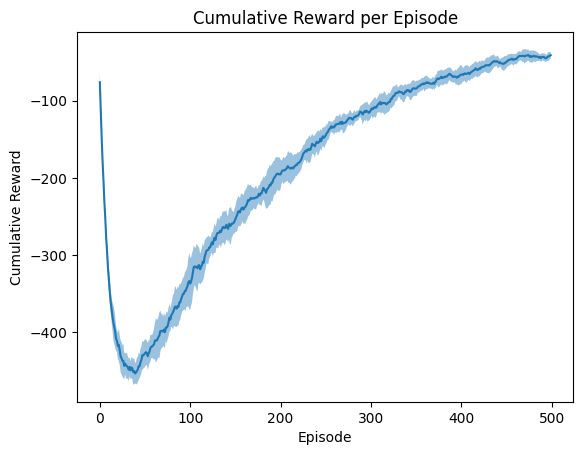

In [9]:
means = np.mean(runs_list, axis=0)
stds = np.std(runs_list, axis=0)

plt.plot(means)
plt.fill_between(range(EPISODES), means-stds,means+stds,alpha=.45)
plt.title('Cumulative Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward');

## $n$-step Q Learning

In [10]:
EPISODES = 500
RUNS = 10

average_cumulative_reward = 0.0
runs_list = np.zeros(shape=(RUNS, EPISODES))
n = 4  # n-step QL


for i in range(RUNS):
    agent = n_QLearning(n_states, n_actions)
    avg_cumulative_list = []
    print(f"Agent: {i+1}")

    for ep in range(EPISODES):
        state = env.reset()[0]

        states = [state]
        actions = []
        rewards = []

        done = False
        cumulative_reward = 0.0
        T = float('inf')
        t = 0

        while True:
            if t < T:
                action = choose_action(agent, state)
                next_state, reward, done, truncated, info = env.step(action)  # Take action

                rewards.append(reward)
                states.append(next_state)
                actions.append(action)

                if done or truncated:
                    T = t + 1

            tau = t - n + 1 # Time whose state's estimate is being updated, state to be updated
            if tau >= 0:
                agent.update(states, actions, rewards, tau, T, done)

                # Update statistics
                cumulative_reward += rewards[tau]

            state = next_state

            if tau == T - 1:
                break
            t += 1
        # Per-episode statistics
        average_cumulative_reward *= 0.95
        average_cumulative_reward += 0.05 * cumulative_reward
        avg_cumulative_list.append(average_cumulative_reward)

        # epsilon = np.exp(-decay*ep)

        if ep % 50 == 0:
            print(f"Episode: {ep} \tAvg cumul reward: {average_cumulative_reward:.4f}, \t {cumulative_reward}")

    print()
    runs_list[i] = np.array(avg_cumulative_list)

avg_ql = evaluate_policy(env, agent.Q, 10)
print(f"\n- Avg reward over 10 episodes: {avg_ql}\n")

[n-step QLearning AGENT SET]

Agent: 1
Episode: 0 	Avg cumul reward: -31.7000, 	 -634.0
Episode: 50 	Avg cumul reward: -609.0082, 	 -489.0
Episode: 100 	Avg cumul reward: -354.8332, 	 -9.0
Episode: 150 	Avg cumul reward: -186.7740, 	 -140.0
Episode: 200 	Avg cumul reward: -140.8004, 	 -31.0
Episode: 250 	Avg cumul reward: -88.9215, 	 -78.0
Episode: 300 	Avg cumul reward: -54.3453, 	 -6.0
Episode: 350 	Avg cumul reward: -38.0801, 	 4.0
Episode: 400 	Avg cumul reward: -39.7815, 	 -6.0
Episode: 450 	Avg cumul reward: -10.5790, 	 6.0

[n-step QLearning AGENT SET]

Agent: 2
Episode: 0 	Avg cumul reward: -63.5807, 	 -948.0
Episode: 50 	Avg cumul reward: -636.0351, 	 -396.0
Episode: 100 	Avg cumul reward: -386.7610, 	 -368.0
Episode: 150 	Avg cumul reward: -281.1125, 	 -2.0
Episode: 200 	Avg cumul reward: -138.0748, 	 -51.0
Episode: 250 	Avg cumul reward: -115.5725, 	 4.0
Episode: 300 	Avg cumul reward: -67.3762, 	 -8.0
Episode: 350 	Avg cumul reward: -19.7355, 	 1.0
Episode: 400 	Avg cumul r

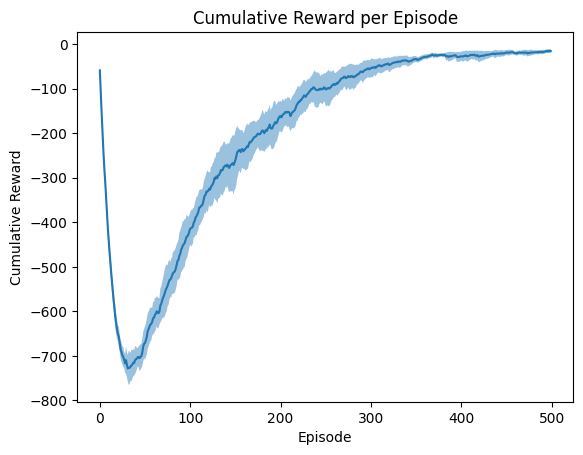

In [11]:
means_Nql = np.mean(runs_list, axis=0)
stds_Nql = np.std(runs_list, axis=0)

plt.plot(means_Nql)
plt.fill_between(range(EPISODES), means_Nql-stds_Nql,means_Nql+stds_Nql,alpha=.45)
plt.title('Cumulative Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward');

# Together

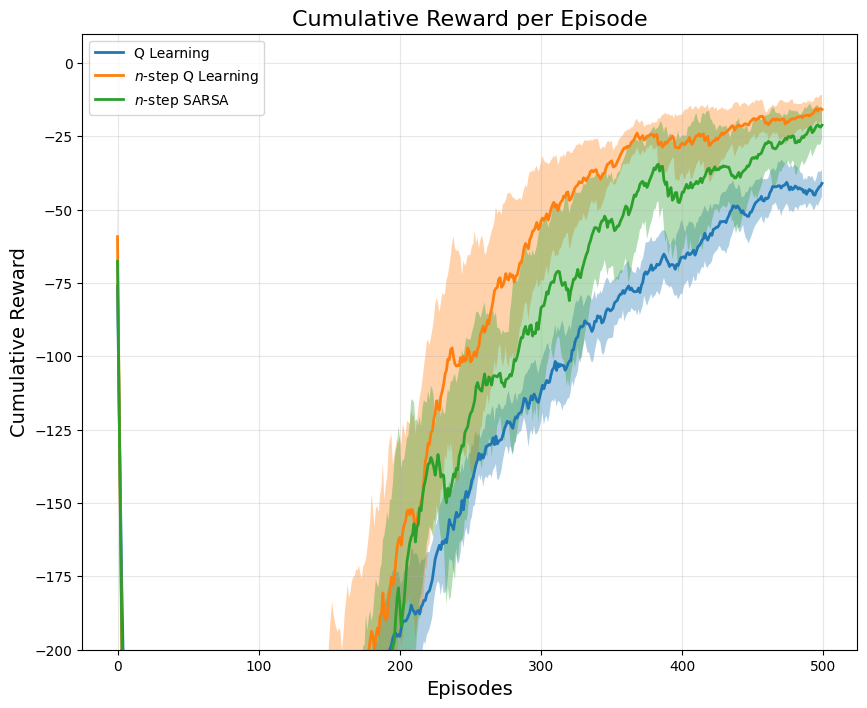

In [13]:
plt.figure(figsize=(10, 8))

plt.plot(means, label='Q Learning', linewidth=2)
plt.plot(means_Nql, label='$n$-step Q Learning', linewidth=2)
plt.plot(means_Nsarsa, label="$n$-step SARSA", linewidth=2)

plt.fill_between(range(EPISODES), means-stds,means+stds,alpha=.35)
plt.fill_between(range(EPISODES), means_Nql-stds_Nql,means_Nql+stds_Nql,alpha=.35)
plt.fill_between(range(EPISODES), means_Nsarsa-stds_Nsarsa, means_Nsarsa+stds_Nsarsa, alpha=.35)

plt.title('Cumulative Reward per Episode', fontsize=16)
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Cumulative Reward', fontsize=14);
plt.grid(True, alpha=.3)
plt.ylim(-200, 10)
plt.legend();